In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pylab as plt

import numpy as np

In [2]:
from colorterms import colorfits as colorterms, filtersets as F, catalogs as C, spectools as S

In [3]:
catalogs = C.load_catalogs()

INFO: Loading the 'pickles1998' catalog
INFO: Loading the 'gunnstryker' catalog
INFO: Loading the 'calspec' catalog


In [4]:
cat = catalogs['gunnstryker']

In [5]:
spec = cat.spectra[0]

In [9]:
filters = F.Filters() # colorterms.Spectrum(lbda, flux, fpath="../filtersets")

INFO: Loading megacam filter set
 - loading g
 - loading i
 - loading r
 - loading u
 - loading z
INFO: Loading megacam2 filter set
 - loading g
 - loading i2
 - loading r
 - loading u
 - loading z
INFO: Loading megacam3 filter set
 - loading g
 - loading i
 - loading r
 - loading u
 - loading z
INFO: Loading sdss filter set
 - loading g
 - loading i
 - loading r
 - loading u
 - loading z
INFO: Loading decam filter set
 - loading g
 - loading i
 - loading r
 - loading u
 - loading z
 - loading Y
INFO: Loading hsc filter set
 - loading g
 - loading i
 - loading r
 - loading Y
 - loading z
INFO: Loading pan-starrs filter set
 - loading g
 - loading i
 - loading r
 - loading y
 - loading z


In [14]:
mag = S.Magnitude(spec, filters)

In [15]:
magMega = mag.mag(syst='megacam', filt='g')
magSDSS = mag.mag(syst='sdss', filt='g')
print(magMega, magSDSS)

(-38.67289197460465, None) (-38.19759506605211, None)


In [16]:
# shortcut
magobjs = [S.Magnitude(spec, filters) for spec in cat.spectra]
magMega = np.array([mag.mag(syst='megacam', filt='g')[0] for mag in magobjs])
magSDSS = np.array([mag.mag(syst='sdss', filt='g')[0] for mag in magobjs])

In [17]:
mags = {}
for syst in filters.filters:
    mags[syst] = {}
    for filt in filters.filters[syst]:
        mags[syst][filt] = np.array([mag.mag(syst=syst, filt=filt)[0] for mag in magobjs])

/home/chotard/anaconda3/lib/python3.6/site-packages/colorterms/spectools.py:95: RuntimeWarning: invalid value encountered in log
  outmag = -2.5 / np.log(10) * np.log(photons)  # / refphotons)


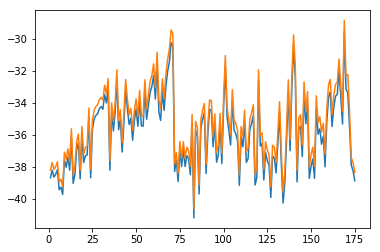

In [18]:
x = np.array([spec.object_name for spec in cat.spectra])
plt.plot(x, magMega, x, magSDSS)

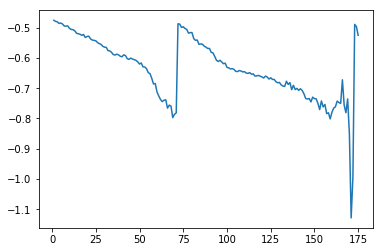

In [19]:
plt.plot(x, np.asarray(magMega)-np.asarray(magSDSS))

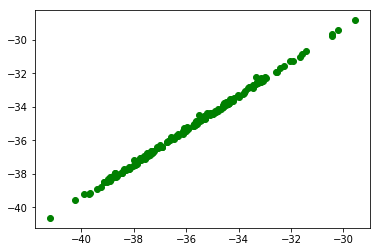

In [20]:
plt.plot(mags['megacam']['g'], mags['sdss']['g'], 'og')

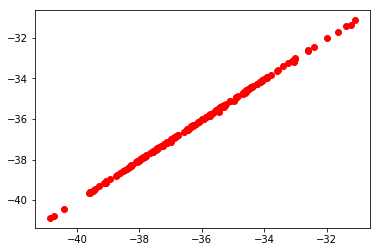

In [21]:
plt.plot(mags['sdss']['r'], mags['megacam']['r'] + 0.011 * (mags['megacam']['g'] - mags['megacam']['r']), 'or')

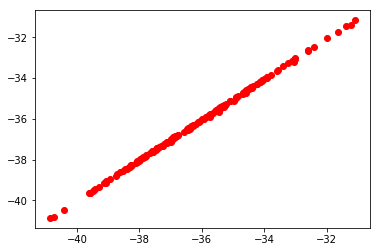

In [22]:
plt.plot(mags['sdss']['r'], mags['megacam']['r'], 'or')

(array([ 29.,  24.,  24.,  40.,  27.,  20.,   6.,   3.,   0.,   2.]),
 array([-0.00839028, -0.00475241, -0.00111454,  0.00252333,  0.0061612 ,
         0.00979907,  0.01343694,  0.01707481,  0.02071268,  0.02435055,
         0.02798841]),
 <a list of 10 Patch objects>)

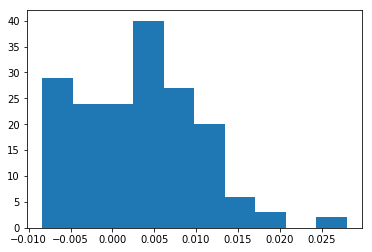

In [23]:
plt.hist(0.011 * (mags['megacam']['g'] - mags['megacam']['r']))

In [24]:
from scipy.optimize import minimize

In [25]:
def lin(params, f0=None, f1=None, f2=None):
    return sum((f0 - f1 - params[0] * f2) ** 2)

def square(params, f0=None, f1=None, f2=None):
    return sum((f0 - f1 - params[0] * f2 - params[1] * f2 ** 2) ** 2)

In [26]:
#m0 = mags['sdss']['r']
#m1 = mags['megacam']['r']
#c1 = mags['megacam']['g'] - mags['megacam']['r']
m0 = mags['megacam']['r']
m1 = mags['sdss']['r']
c1 = mags['sdss']['g'] - mags['sdss']['r']

In [27]:
out = minimize(lin, (0.), args=(m0, m1, c1))
print(out)

      fun: 0.05015317115607986
 hess_inv: array([[1]])
      jac: array([  5.74160367e-07])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.04766993])


In [28]:
out2 = minimize(square, (0., 0.), args=(mags['sdss']['r'], mags['megacam']['r'], mags['megacam']['g'] - mags['megacam']['r']))
print(out)

      fun: 0.05015317115607986
 hess_inv: array([[1]])
      jac: array([  5.74160367e-07])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.04766993])


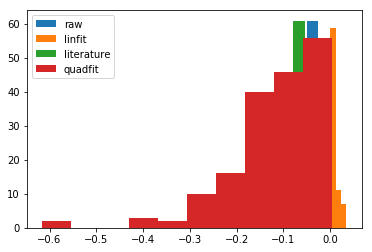

In [29]:
plt.hist(m0 - m1, label='raw')
plt.hist(m0 - m1 - out.x[0] * c1, label='linfit')
plt.hist(m0 - m1 - 0.011 * c1, label='literature')
plt.hist(m0 - m1 - out2.x[0] * c1 - out2.x[1] * c1 ** 2, label='quadfit')
plt.legend(loc='best')

In [30]:
def mean_std(x): 
    return np.mean(x), np.std(x)

In [31]:
print('raw', mean_std(m0 - m1))
print('linfit', mean_std(m0 - m1 - out.x[0] * c1))
print('literature', mean_std(m0 - m1 - 0.011 * c1))
print('quadfit', mean_std(m0 - m1 - out2.x[0] * c1 - out2.x[1] * c1 ** 2))

raw (-0.046146722511596502, 0.034071082811279366)
linfit (-0.003262299221178573, 0.016611651129698431)
literature (-0.056042451037271908, 0.041180151891958984)
quadfit (-0.1156153069930526, 0.10199660548931185)


In [32]:
from scipy import polyfit, polyval

In [33]:
p1 = polyfit(c1, m0 - m1, 1)
p2 = polyfit(c1, m0 - m1, 2)
p3 = polyfit(c1, m0 - m1, 3)
print(p1)
print(p2)
print(p3)

[-0.04194386 -0.00841354]
[-0.00961909 -0.02170256 -0.01390799]
[ 0.0016634  -0.01648966 -0.01544848 -0.01422448]


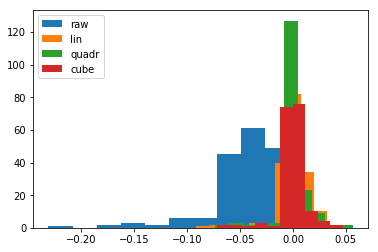

In [34]:
plt.hist(m0 - m1, label='raw')
plt.hist(m0 - m1 - polyval(p1, c1), label='lin')
plt.hist(m0 - m1 - polyval(p2, c1), label='quadr')
plt.hist(m0 - m1 - polyval(p3, c1), label='cube')
plt.legend(loc='best')

In [35]:
print('raw',  mean_std(m0 - m1))
print('lin',  mean_std(m0 - m1 - polyval(p1, c1)))
print('quad', mean_std(m0 - m1 - polyval(p2, c1)))
print('cube', mean_std(m0 - m1 - polyval(p3, c1)))

raw (-0.046146722511596502, 0.034071082811279366)
lin (1.2529659849341052e-17, 0.016097889007296699)
quad (1.1102230246251566e-18, 0.014427835459948458)
cube (-1.3639882873966209e-17, 0.014367236776896377)


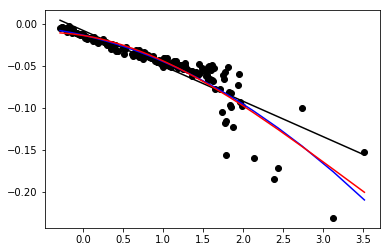

In [36]:
plt.plot(c1, m0 - m1, 'ok')
plt.plot(sorted(c1), polyval(p1, sorted(c1)), 'k')
plt.plot(sorted(c1), polyval(p2, sorted(c1)), 'b')
plt.plot(sorted(c1), polyval(p3, sorted(c1)), 'r')

In [37]:
for f0 in mags['megacam']:
    m0 = mags['megacam'][f0]
    
m1 = mags['sdss']['r']
c1 = mags['sdss']['g'] - mags['sdss']['r']

In [38]:
colt = colorterms.Colorterms(catalogs, filters)

/home/chotard/anaconda3/lib/python3.6/site-packages/colorterms/spectools.py:95: RuntimeWarning: invalid value encountered in log
  outmag = -2.5 / np.log(10) * np.log(photons)  # / refphotons)
/home/chotard/anaconda3/lib/python3.6/site-packages/colorterms/spectools.py:95: RuntimeWarning: divide by zero encountered in log
  outmag = -2.5 / np.log(10) * np.log(photons)  # / refphotons)


In [39]:
colt.magnitudes

{'calspec_bestofall': {'decam': {'Y': array([ -8.547711  ,  -1.49109373,  -1.64440728,  -0.7319042 ,
           -2.41336644,  -1.939553  ,  -1.72752275,  -2.05439438,
           -2.38777395,  -1.82182749,  -0.07579938,   1.25200266,
           -1.24690325, -13.83829885,  -4.75801418,  -5.17582846,
           -5.39519272,   4.18412799,  -4.92722143,  -2.20443326,
           -4.46566029,   6.09590151,  -4.93611347,  -4.19514124,
           -3.16393177,   1.84340295,  -1.92183602,  -1.40660008,
           -1.7198497 ,   5.06548208,   6.06851787,  -1.41470946,
            8.04023987,   8.4229147 ,   0.13327831,   8.33006913,
           -0.20803859,  -1.48339324,  -0.61596973,  -6.19816624,
           -5.53381734,  -4.93262763,  -7.28503174,  -6.34749912,
           -5.4349465 ,  -8.20412578,  -7.57125802,  -8.19602725,
           -5.93380305,  -7.28598009,  -7.15315884,  -4.61157217,
           -6.68843916,  -5.86795703,  -7.96397845,  -6.98108996,
           -5.76940394,  -6.91539342,  -6

In [40]:
first_filterset = 'decam'; second_filterset='sdss'

In [41]:
first_means = {filt: filters.filters[first_filterset][filt].mean_wlength() for filt in filters.filters[first_filterset]}

In [42]:
second_means = {filt: filters.filters[first_filterset][filt].mean_wlength() for filt in filters.filters[second_filterset]}

In [43]:
first_means, second_means

({'Y': 10091.78754950411,
  'g': 4734.3847396976316,
  'i': 7832.6635227866254,
  'r': 6416.0083404952893,
  'u': 3563.5722855103404,
  'z': 9259.6987729563534},
 {'g': 4734.3847396976316,
  'i': 7832.6635227866254,
  'r': 6416.0083404952893,
  'u': 3563.5722855103404,
  'z': 9259.6987729563534})

In [44]:
colt.pair_filters_between_systems(first_filterset, second_filterset)

decam u ['z' 'i' 'r' 'g' 'u']
decam g ['z' 'i' 'r' 'g' 'u']
decam r ['z' 'i' 'r' 'g' 'u']
decam i ['z' 'i' 'r' 'g' 'u']
decam z ['z' 'i' 'r' 'g' 'u']
decam Y ['z' 'i' 'r' 'g' 'u']
